# P3: Project Results (Sigma Squad)

* [1. Analysis of the Final Merged Dataset](#1-analysis-of-the-final-merged-dataset)
* [2. Movie Success Index](#2-movie-success-index)
* [3. Actor Success Index](#3-actor-success-index)
* [4. Preparing Actor Data for Analysis](#4-preparing-actor-data-for-analysis)
* [5. Quick Overview of the Actor Data](#5-quick-overview-of-the-actor-data)
* [6. Analysis](#6-analysis)

## 1. Analysis of the Final Merged Dataset:

After loading and merging our 3 datasets, we obtained the final raw dataset. It's composition can be seen below.

In [1]:
from src.data import raw_data

# delete this after
import pandas as pd
raw_df = pd.read_csv('data_for_results_(delete_after)/raw_data.csv')
# Set the default template to plotly_dark
import plotly.io as pio
pio.templates.default = "plotly_dark"

#raw_df = raw_data()
raw_df.head()

,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Review score,Movie votes,Movie director,Movie star,Movie budget,Movie gross,Movie company,Number of nomination,Nomination winner
0,/m/03vyhn,ghosts_of_mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",4.9,52000.0,John Carpenter,Natasha Henstridge,28000000.0,14010832.0,Screen Gems,NaN,NaN
1,/m/08yl5d,getting_away_with_murder:_the_jonbenét_ramsey_...,2000.0,NaN,95.0,"{""/m/02h40lc"": ""English Language""}",United States of America,"Mystery, Biographical film, Drama, Crime Drama",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,/m/0crgdbh,brun_bitter,1988.0,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}",Norway,"Crime Fiction, Drama",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,/m/0285_cd,white_of_the_eye,1987.0,NaN,110.0,"{""/m/02h40lc"": ""English Language""}",United Kingdom,"Thriller, Erotic thriller, Psychological thriller",6.2,2200.0,Donald Cammell,David Keith,NaN,NaN,Mrs. White's Productions,NaN,NaN
4,/m/01mrr1,a_woman_in_flames,1983.0,NaN,106.0,"{""/m/04306rv"": ""German Language""}",Germany,Drama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In order to proceed with our analysis, we need to deal with the NaN values.  

### The bar plot below shows how many movies have valid values in categories, that are important for our further computations.

In [2]:
from src.utils import bar_plot_available_data

bar_plot_available_data(raw_df)

To establish the movie success index, we are focused on specific criteria such as budget, revenues, ratings, number of Oscar nominations, and the movie profitability. Our goal is to assess whether we have enough reliable data to effectively study these factors.  

We analyzed the available data and observed that the original CMU Movie dataset contains 8 401 movies with revenue data. From the additional datasets, we identified movies that meet other key criteria, including budget (4 148 movies) and review score (5 605 movies).  

### Finally, we have 3 537 movies that have all required information combined. 

In [3]:
from src.data import clean_data

movie_df = clean_data(raw_df)
print(f'The length of the working dataset of movies that have all required informations is {len(movie_df)}.')

The length of the working dataset of movies that have all required informations is 3537.


Given this sample size, we are confident that we have sufficient and reliable data to move forward with constructing the success index. The next step will be to normalize and properly weight each criterion to build the success index.

## 2. Movie Success Index:

To create our success index, we evaluated movie success based on four key factors: **profitability**, **revenue**, **reviews**, and **Oscar nominations**. Both profitability and revenue were scaled using min-max normalization, providing a consistent framework to evaluate and compare success across variables with different ranges. 

After calculating the factors, we combined them into a final index. Profitability, revenue, and review factors are weighted (35%, 35%, and 30%, respectively) and adjusted by the Oscar factor. The resulting index is normalized again to a 0-10 scale, offering a single score representing each movie’s overall success.

Here is a more detailed explanation of the setup of each factor. Note that all functions used can be found in the `src/movie_success_model.py` file.

- **Profitability factor:** this factor measures how much revenue a movie generates relative to its budget. First, the profitability ratio (revenue divided by budget) is calculated. To reduce the impact of outliers, a logarithmic transformation (log) is applied, which compresses large values and accentuates smaller ones. The result is normalized to a 0-10 scale, making comparisons across movies straightforward.

- **Revenue factor:** this factor focuses solely on the movie's box office revenue. A log10 transformation is applied to balance the range of high and low revenues, particularly since box office numbers can vary greatly. After applying the transformation, scores are scaled from 0 to 10 for consistency.

- **Review factor:** this factor is directly taking the ImdB movie ratings which were already on a scale from 0 to 10.

- **Oscar multiplication factor:** this factor amplifies the success index based on Oscar nominations, recognizing industry recognition as a mark of success. The function uses a logarithmic transformation for diminishing returns, giving a smaller increase for each additional nomination, then scales by a multiplier to ensure consistent weighting.

In [4]:
from src.models import movie_success_index

movie_success_index(movie_df)

### Below you can find plots showing the 'Profitability' and 'Revenue' factors

Initially, you can observe the absolute distributions, which show a heavy-tailed pattern. Subsequently, the distributions are shown after applying a logarithmic transformation to reduce the impact of extreme values.

Note: After applying the log transformation, we scaled the values to a range of 0 to 10, as previously mentioned.

In [5]:
from src.utils import profitability_histograms, movie_revenue_distribution_plot

profitability_histograms(movie_df)

In [6]:
movie_revenue_distribution_plot(movie_df)

### The reviews remain unchanged; the distribution is shown below

In [7]:
# !!!!! add review of the model here !!!!! Is somewhere a plot???
from src.utils import plot_movie_review_distribution

plot_movie_review_distribution(movie_df)

### Oscar nominations across movies.
The chart illustrating this distribution is shown below.

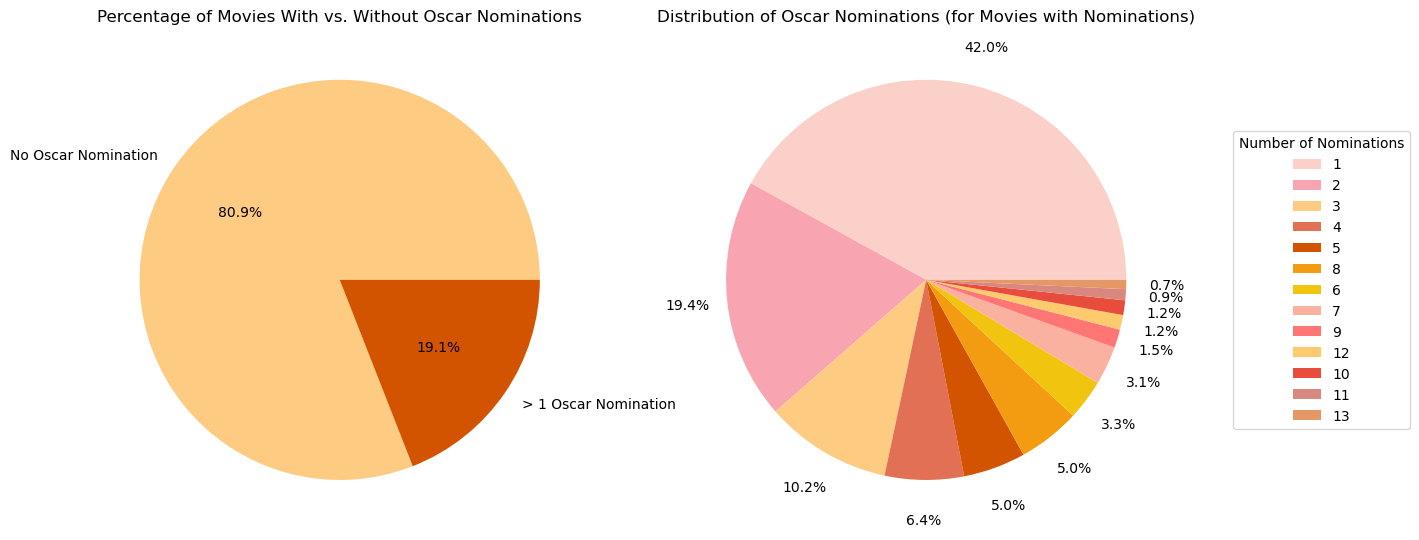

In [8]:
from src.utils import oscar_pie_chart

oscar_pie_chart(movie_df)

On the left pie, we can see that only 19.1% of our analyzed movies have any Oscar nomination. Thus, we decided to create a multiplication factor, that will be multiplied with the final movie success index. Movies that have Oscar nominations will benefit from that multiplication factor, but the other movies won't be penalized. Moreover, the more nominations, the higher the multiplication factor.

### Finally, by combining all four factors, we obtain the distribution of the movie score index shown below

In [9]:
from src.utils import movie_score_distribution_plot

movie_score_distribution_plot(movie_df)

### ***Example of ranking based on our movie success index :*** top 5 best and worst movies

In [10]:
from src.utils import top5_best, top5_worst

top5_best(movie_df)

,Movie name,Movie release date,Movie Success Index,Review score,Revenue score,Profitability score
80920,the_lord_of_the_rings:_the_return_of_the_king,2003.0,7.916470,8.9,9.257307,5.999965
79973,the_lord_of_the_rings:_the_fellowship_of_the_ring,2001.0,7.850975,8.8,9.052642,5.835857
65287,forrest_gump,1994.0,7.844366,8.8,8.846968,6.022649
57552,e.t._the_extra-terrestrial,1982.0,7.818620,7.8,8.975484,7.262251
23702,avatar,2009.0,7.734081,7.8,10.000000,5.989874


In [11]:
top5_worst(movie_df)

,Movie name,Movie release date,Movie Success Index,Review score,Revenue score,Profitability score
8416,deadfall,1993.0,1.034197,4.0,0.264990,0.000000
19093,dangerous_game,1993.0,1.524680,5.6,0.471943,0.173344
10467,wicked_stepmother,1989.0,1.735934,4.3,0.973217,1.540833
76763,the_specials,2000.0,1.770565,5.8,0.000000,1.352018
58128,best_laid_plans,1999.0,1.780705,6.1,0.603631,0.527457


## 3. Actor Success Index:

### Idea of the index

Now that we have established our movie success index we can move on to creating an actor success index. The goal is to be able to quantitatively compare the success of an actor and their career given the success of their movies. The main challenge here is finding a meaningful way to do so. To illustrate, our initial attempts at building the index relied on a mean of scores over an actors career. However, with this method, the most successful actors where side characters that starred in only one or two movies, but that happened to be huge successes. The index therefore needs to account not only for the absolute success of the movies but also for the amount of quality movies and the consistency of success.

### Main character bonus

The first thing we do when establishing the score is identifying main characters. Being chosen for the most prominent role of a movie is a certificate of trust from the production company. This is why we boost the movie score in which an actor is the star by 25% before processing it further. This is a way to account for desirability in the movie industry.

### Multiplier & Streak

To build the actor score, we have come up with a multiplier and streak system. For every actor, the movies are sorted by release date in ascending order. From the score of every movie, a multiplier is generated. If the score is within 25% of the last movie or better, the multiplier is generated proportionaly from the movie score (it is greater than 1, see code for the formula). If the score of the movie happens to be more than 25% worse than the last, the multiplier is generated proportionally to the percent difference between both successive movies (multiplier smaller than 1). This way, successive successful movies grow the cumulative multiplier, whilst inconsistencies and drops in quality decrease it. This systems values an actors ability to be consistent in the quality of their work. Moreover, repeatedly getting casted is an indicator for industry desirability. This means the system allows us to better capture the value an actor has had over their career.

### Final grade

 The product of all multipliers up to the current one (cumulative multiplier) is applied to the current movie score and the product is added to an array. This array therefore holds all movie scores of an actor, scalled by their respective cumulative multiplier. The array is then summed and a log10 is applied to the sum. The results are normalized using min-max normalization to obtain a comparable grade out of 10. 

### Below you may find plots for the distribution of the actor scores and a table for the most and least successful actors acording to our ranking

In [12]:
from src.models import actor_success_index
from src.data import actor_data

# delete this after
actor_df = pd.read_csv('data_for_results_(delete_after)/actor_data.csv', index_col=0)

#actor_df = actor_data(movie_df)
#actor_df = actor_success_index(actor_df)

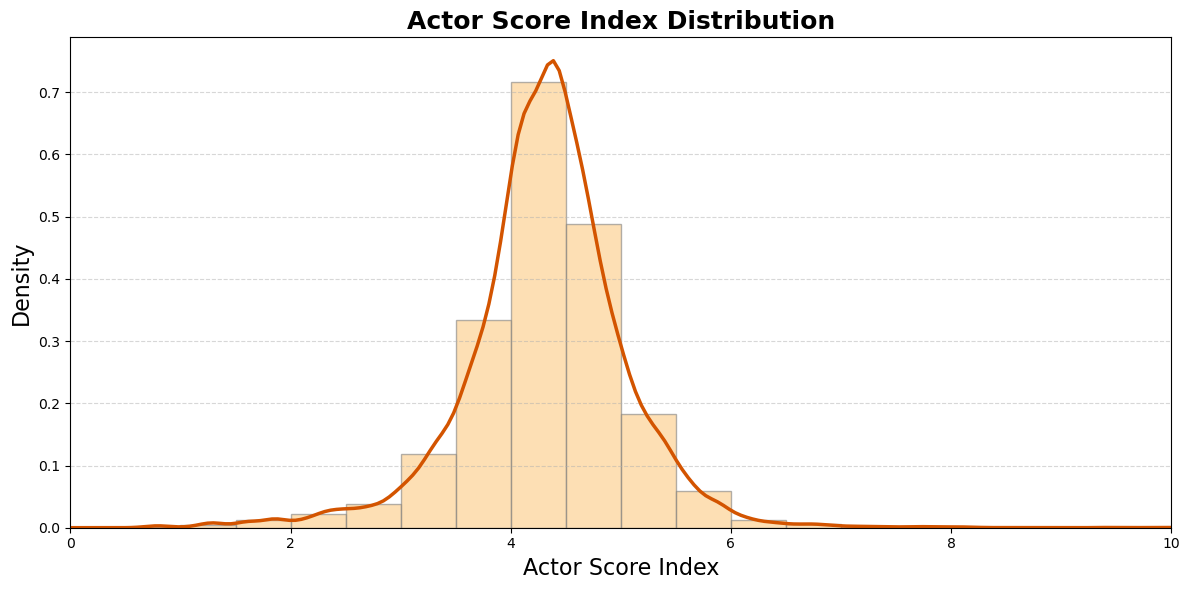

In [13]:
from src.utils import hist_std_config

hist_std_config(actor_df, 'Actor Score Index')

In [14]:
actor_df['Actor Score Index']

Actor name
denzel_washington      10.000000
matt_damon              9.912690
tom_hanks               9.741555
eddie_murphy            9.415060
tom_cruise              9.362255
                         ...    
j._kenneth_campbell     0.714754
evelyn_keyes            0.700949
james_dixon             0.700949
reilly_murphy           0.251820
peter_fonda             0.000000
Name: Actor Score Index, Length: 20693, dtype: float64

Notice how the results from the model somewhat align with our expectations, but also bring about interesting results: why is Peter Fonda so low on the score index? Inspection of the data shows a strong drop in movie quality at the end of his career which was picked up on by the multiplier & streak model. 

The above scores and rankings give us confidence in the quality of our preliminary analysis.

## 4. Preparing Actor Data for Analysis

### Data Reduction and Justification

Now that we have out actor dataset, we need to prepare it further for the regression analysis. Our dataset consists of 20'693 actors with various attributes, including the actor success index, actor date of birth, actor gender, and more. Due to the large size of the dataset and the significant amount of missing data, we needed to reduce the data while maintaining its integrity for analysis.  
The amount of missing data per category can be seen below.

Number of actors in the dataset: 20693


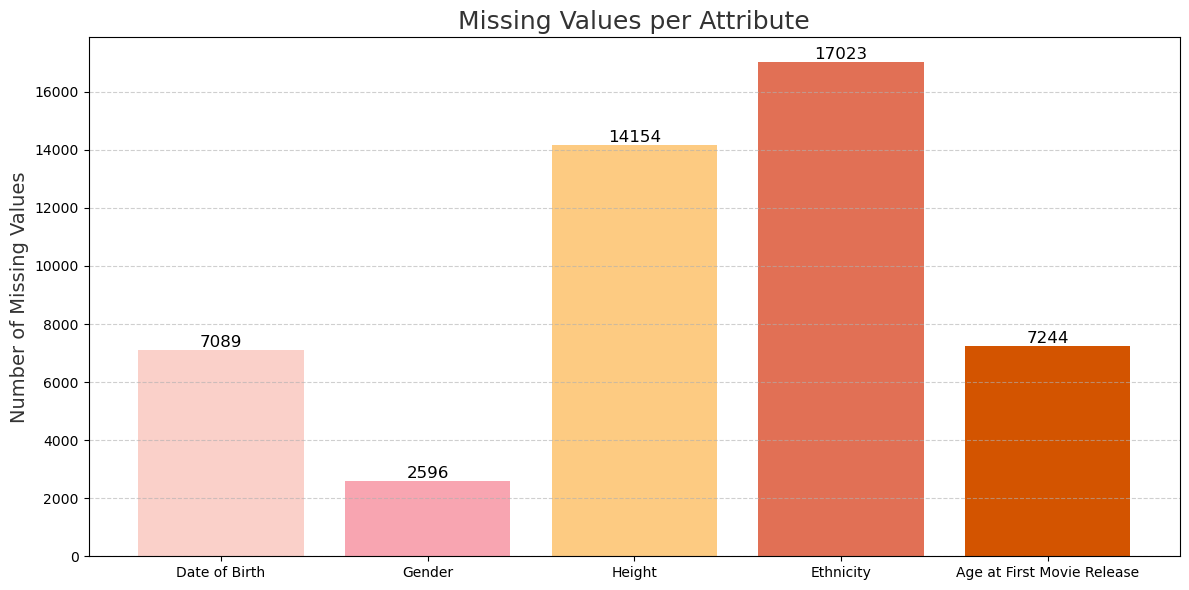

In [15]:
from src.utils import actor_bar_plot

print(f'Number of actors in the dataset: {len(actor_df)}')
actor_bar_plot(actor_df)

We noticed that quite a lot of the data set had missing values for both height and ethnicity. Our attempts to retrieve these missing values through web scraping were unsuccessful.  

Finally, we decided to filter out all actors for whom height information is missing. To be sure that this reduction does not introduce bias, we compared the actor success index distribution before and after filtering.

The left plot shows the Actor Score Index across all actors.
The right plot shows the Actor Score Index across actors with known heights.


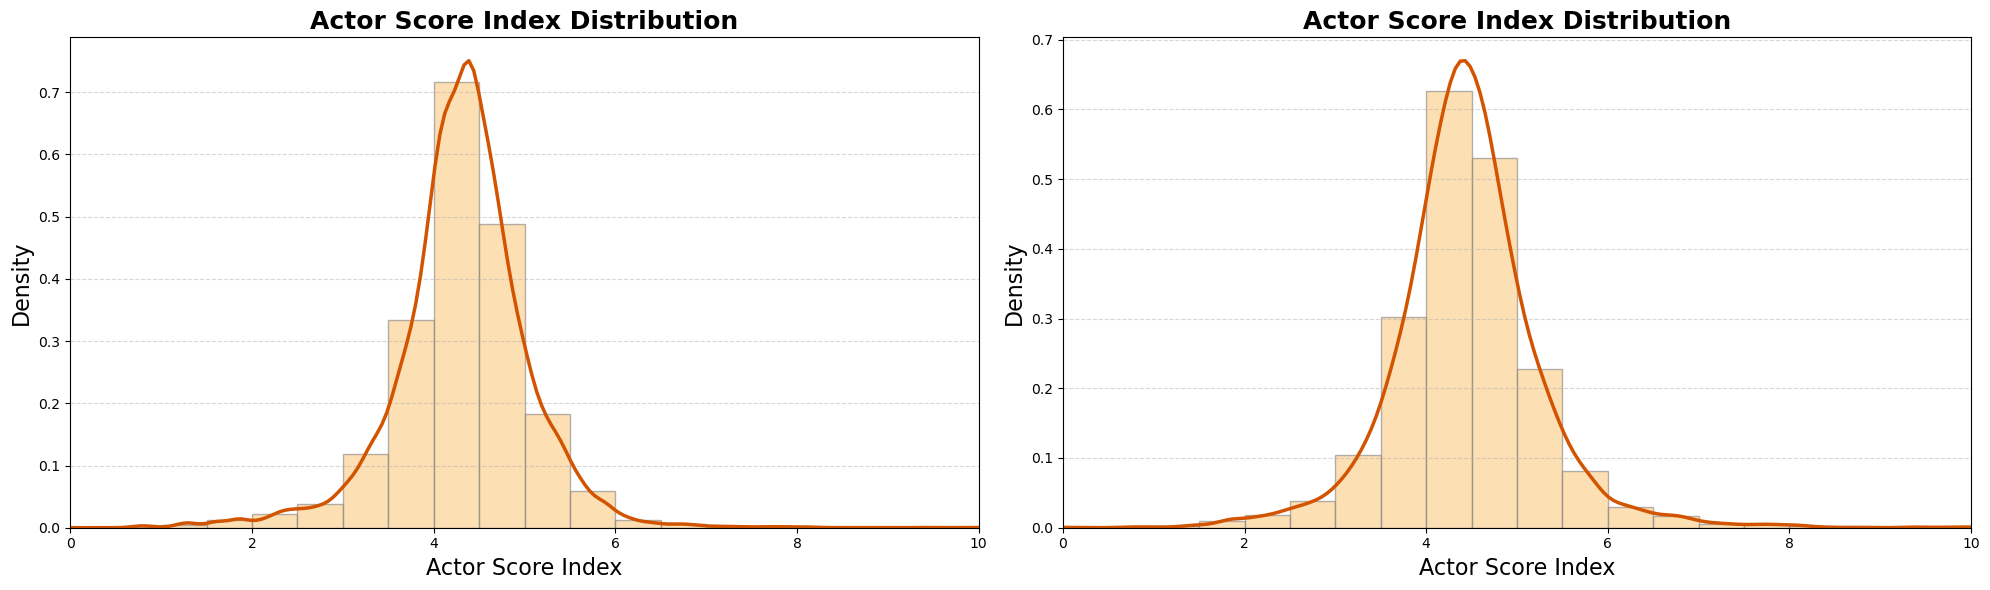

,Mean,Standard Deviation
Dataset,,
All Actors,4.315390,0.726976
Actors with Known Heights,4.443647,0.800041


In [16]:
from src.utils import actor_index_distribution

actor_index_distribution(actor_df)

We can observe the following.

- **Small difference in Means:** Mean for all actors is 4.32, Mean for actors with known heights is 4.44
- **Comparable Standard Deviations:** Std for all actors is 0.73, Std for actors with known heights is 0.80

These values suggest that the filtering process does not disproportionately exclude actors with particularly high or low success index. The distribution of success remains consistent before and after filtering. Given this, we are confident that our analysis will still reflect the overall trends in actor success.

In [17]:
reduced_actor_df = actor_df.dropna(subset='Actor height').copy()

print(f'Number of actors of the reduced dataset of actors with height information: {len(reduced_actor_df)}')

Number of actors of the reduced dataset of actors with height information: 6539


### Adding Data with Web Scraping

To improve the performance of our linear regression model, we enriched our dataset by scraping additional actor attributes from the web. 

- **University:** Educational background, indicating if the actor attended a university and where.
- **Theater:** Involvement in theater (yes or no).
- **Sports:** Participation in sports.
- **Birth City:** The actor's birthplace, can provide geographical context.
- **Citizenship:** Nationality or legal citizenship.
- **Number of Children:** Insights into how personal life may correlate with career longevity.

The full web scraping process is time-consuming, therefore we have pre-scraped the data and will load the enriched dataset directly from memory for the next analysis steps.

Moreover, we encountered issues with a few actors during the web scraping process. We manually filled in some missing data for these actors.

An example of our webscraping process is given below, on the first 5 actors of the actor dataframe.

In [18]:
from src.data import scrape_actor_data

first_actors = reduced_actor_df.iloc[:5].copy()
#scrape_actor_data(first_actors)
first_actors

,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor age at movie release,Actor Score Index
Actor name,,,,,,
denzel_washington,1954-12-28,M,1.84,/m/0x67,26.0,10.000000
matt_damon,1970-10-08,M,1.78,/m/0cnvdq1,18.0,9.912690
tom_hanks,1956-07-09,M,1.83,/m/02p4q5p,27.0,9.741555
eddie_murphy,1961-04-03,M,1.75,/m/0x67,21.0,9.415060
tom_cruise,1962-07-03,M,1.70,/m/02ctzb,18.0,9.362255


### Clean and Process the Data for further Analysis

After obtaining additional data through web scraping, some columns need to be cleaned, while others need to be transformed into more useful formats for analysis.

The following operations are performed on the actor dataset.

1. Rename columns for consistent name labels.
2. Convert ethnicity IDs to their respective ethnicity names.
3. Separate the date of birth into two new columns: 'Birth Year' and 'Birth Month'.
4. Group birth cities by 4 major regions: USA, United Kingdom, Europe and 'Rest of World'.
5. Match University names to their rank according to the QS Rankings 2024.  
    Creation of new indicators per actor for attending uni and the type of uni attended.
8. Convert 'Theater' column to boolean type.

The result of the process can be observed on the example below.

In [19]:
from src.data import clean_actor_data

#clean_actor_data(first_actors)
first_actors

,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor age at movie release,Actor Score Index
Actor name,,,,,,
denzel_washington,1954-12-28,M,1.84,/m/0x67,26.0,10.000000
matt_damon,1970-10-08,M,1.78,/m/0cnvdq1,18.0,9.912690
tom_hanks,1956-07-09,M,1.83,/m/02p4q5p,27.0,9.741555
eddie_murphy,1961-04-03,M,1.75,/m/0x67,21.0,9.415060
tom_cruise,1962-07-03,M,1.70,/m/02ctzb,18.0,9.362255


### Loading the Complete Actor Dataset for Analysis

All the actions mentioned above have already been applied to the complete actor dataset. The resulting CSV file is available as `full_data_for_regression.csv`.

In [20]:
from src.data import load_actor_data_for_analysis

actor_df = load_actor_data_for_analysis()
actor_df

,Gender,Height,Ethnicity,Age at First Release,Success Score,University,Theater,Sports,Birth City,Citizenship,...,Birth Year,Birth Month,QS University Rank,Ranked Uni,Usable Uni Rank,Specialised Drama School,Specialised Acting School,Specialised Dance School,Specialised Arts School,Birth Region
Actor name,,,,,,,,,,,,,,,,,,,,,
Denzel Washington,M,1.840,African Americans,26,10.000000,Specialised Drama School,True,Basketball,Mount Vernon New York US,NaN,...,1954,December,Not Ranked,0,3000,1,0,0,0,USA
Matt Damon,M,1.780,Scandinavian Americans,18,9.912690,Harvard University,True,No Sports,Cambridge Massachusetts US,NaN,...,1970,October,4,1,4,0,0,0,0,USA
Tom Hanks,M,1.830,Portuguese Americans,27,9.741555,sub 1500 school,True,No Sports,Concord California US,"United States, Greece1",...,1956,July,Not Ranked,0,3000,0,0,0,0,USA
Eddie Murphy,M,1.750,African Americans,21,9.415060,Did not go,False,No Sports,New York City US,NaN,...,1961,April,Not Ranked,0,3000,0,0,0,0,USA
Tom Cruise,M,1.700,White people,18,9.362255,Did not go,False,Football,Syracuse New York US,NaN,...,1962,July,Not Ranked,0,3000,0,0,0,0,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Lindsay Hollister,F,1.750,NaN,30,1.103153,Miami University,False,No Sports,Columbus Ohio United States,NaN,...,1977,June,1201,1,1201,0,0,0,0,USA
Terrence Howard,M,1.840,African Americans,26,0.915104,Did not go,False,Track,Chicago Illinois US,NaN,...,1969,March,Not Ranked,0,3000,0,0,0,0,USA
Madonna,F,1.613,French Canadians,26,0.838557,Did not go,False,No Sports,Bay City Michigan US,NaN,...,1958,August,Not Ranked,0,3000,0,0,0,0,USA


## 5. Quick Overview of the Actor Data

## 6. Analysis


In [21]:

from src.data.correlation import display_correlation, encode_categorical

encoded = encode_categorical(actor_df,['Gender'])
display_correlation(encoded )



ValueError: could not convert string to float: 'African Americans'

## With Ethnicity Analysis

#### Purpose of Ethnicity Mapping
The ethnicity mapping in our project serves to categorize various ethnic groups into broader categories. This is done to simplify the analysis and ensure that the data is manageable and interpretable. By grouping specific ethnicities into larger categories, we can reduce the complexity of the dataset and focus on broader trends and patterns.  
#### Why Include Ethnicity in Correlation and Regression Analysis
1. Understanding Demographic Influence: Including ethnicity as a feature in our correlation and regression analysis allows us to understand how different demographic groups may influence the success score. This can help identify if certain ethnic groups have a significant impact on the outcome variable.  
2. Identifying Biases: By analyzing the correlation between ethnicity and success scores, we can identify potential biases in the data. This is crucial for ensuring that our models are fair and do not inadvertently favor or disadvantage any particular group.  
3. Improving Model Accuracy: Ethnicity can be an important predictor variable. Including it in our regression models can improve the accuracy of our predictions by accounting for variations in success scores that may be attributed to ethnic background.

In [4]:
from src.data.correlation import ethnicity_to_group
ethnic_group = ethnicity_to_group(actor_df)

ethnic_group

,Gender,Height,Ethnicity,Age at First Release,Success Score,University,Theater,Sports,Birth City,Citizenship,...,Birth Year,Birth Month,QS University Rank,Ranked Uni,Usable Uni Rank,Specialised Drama School,Specialised Acting School,Specialised Dance School,Specialised Arts School,Birth Region
Actor name,,,,,,,,,,,,,,,,,,,,,
Denzel Washington,M,1.840,African Descent,26,10.000000,Specialised Drama School,True,Basketball,Mount Vernon New York US,NaN,...,26,December,Not Ranked,0,3000,1,0,0,0,USA
Matt Damon,M,1.780,European Descent,18,9.912690,Harvard University,True,No Sports,Cambridge Massachusetts US,NaN,...,18,October,4,1,4,0,0,0,0,USA
Tom Hanks,M,1.830,European Descent,27,9.741555,sub 1500 school,True,No Sports,Concord California US,"United States, Greece1",...,27,July,Not Ranked,0,3000,0,0,0,0,USA
Eddie Murphy,M,1.750,African Descent,21,9.415060,Did not go,False,No Sports,New York City US,NaN,...,21,April,Not Ranked,0,3000,0,0,0,0,USA
Tom Cruise,M,1.700,European Descent,18,9.362255,Did not go,False,Football,Syracuse New York US,NaN,...,18,July,Not Ranked,0,3000,0,0,0,0,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Glenne Headly,F,1.710,European Descent,29,1.786282,Did not go,True,Ballet,New London Connecticut US,NaN,...,29,March,Not Ranked,0,3000,0,0,0,0,USA
Tom Bosley,M,1.676,Jewish Descent,59,1.774135,sub 1500 school,False,No Sports,Chicago Illinois US,NaN,...,59,October,Not Ranked,0,3000,0,0,0,0,USA
Terrence Howard,M,1.840,African Descent,26,0.915104,Did not go,False,Track,Chicago Illinois US,NaN,...,26,March,Not Ranked,0,3000,0,0,0,0,USA


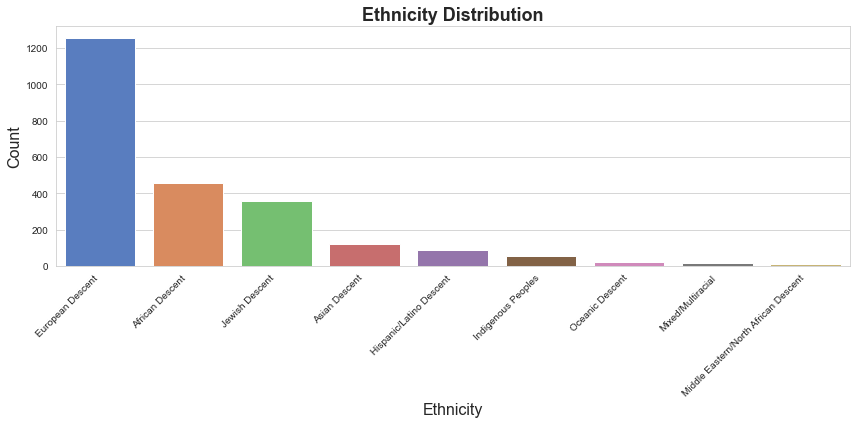

In [5]:
from src.utils.plot_graphs import plot_ethnicity_distribution

plot_ethnicity_distribution(ethnic_group)



In [6]:


encoded_df = encode_categorical(ethnic_group, ['Gender', 'Ethnicity'])
display_correlation(encoded_df)



Gender_M                                          0.076059
Number of Children                                0.068866
Theater                                           0.060592
Ethnicity_European Descent                        0.059123
Ranked Uni                                        0.050445
Specialised Drama School                          0.047545
Ethnicity_Oceanic Descent                         0.036844
Ethnicity_Hispanic/Latino Descent                 0.023053
Height                                            0.022048
Specialised Dance School                          0.013745
Ethnicity_Mixed/Multiracial                       0.012066
Specialised Acting School                         0.005357
Ethnicity_Middle Eastern/North African Descent   -0.003615
Ethnicity_Indigenous Peoples                     -0.016965
Ethnicity_Asian Descent                          -0.026531
Specialised Arts School                          -0.029408
Ethnicity_Jewish Descent                         -0.0322